# Analiza obrazów

Dyskretna transformata Fouriera umożliwa przekształcenie obrazu z domeny czasu do domeny częstotliwościowej. Ze względu na charakterystykę DFT przekształcane obrazy powinny na brzegach mieć nmożliwie iskie wartości, aby uniknąć powstawania artefaktów - zwykle oznacza to konieczność odwrócenia kolorów.

In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm
from numpy.fft import fft2, ifft2

In [2]:
%matplotlib notebook

Poniższe funkcje słuzą do przygotowania danych wejściowych i wizualizacji obrazu wraz z wynikiem jego transformacji.

In [3]:
def load_text(name):
    "loads image and returns it in greyscale with inverted colors"
    img = Image.open(name).convert('L')
    return np.array(ImageOps.invert(img))

def fourier_components(img):
    "splits imaginary array into real components (length, angle)"
    fourier = fft2(img)
    mod = np.absolute(fourier)
    angle = np.angle(fourier)
    return mod, angle

def visualise_dft(img, font_size=20):
    mod, angle = fourier_components(img)
    #mod /= np.max(mod)
    big_num_idx = mod.flatten().argsort()[int((mod.shape[0]*mod.shape[1])*0.99)]
    new_maximum = mod.flatten()[big_num_idx]
    mod[mod>new_maximum] = new_maximum
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,10))
    for ax in axes: ax.axis("off")
    axes[0].imshow(img)
    axes[0].set_title("original image", fontdict={"fontsize": font_size})
    pos = axes[1].imshow(mod)
    fig.colorbar(pos, ax=axes[1])
    axes[1].set_title("modulus of coefficients", fontdict={"fontsize": font_size})
    pos = axes[2].imshow(angle)
    fig.colorbar(pos, ax=axes[2])
    axes[2].set_title("phase of coefficients", fontdict={"fontsize": font_size})
    plt.show()

Poniżej znajduje się wizualizacja współczynników Fouriera (wartości modułu i fazy) dla obrazu z tekstem. Jako, że kilka wartości modułu jest znacząco odstających to na potrzeby wizualizacji są one pomniejszone (wszystkie wartości stanowiące górny 1% są zmienione na najniższą wartość z tego jednego procenta).

<IPython.core.display.Javascript object>


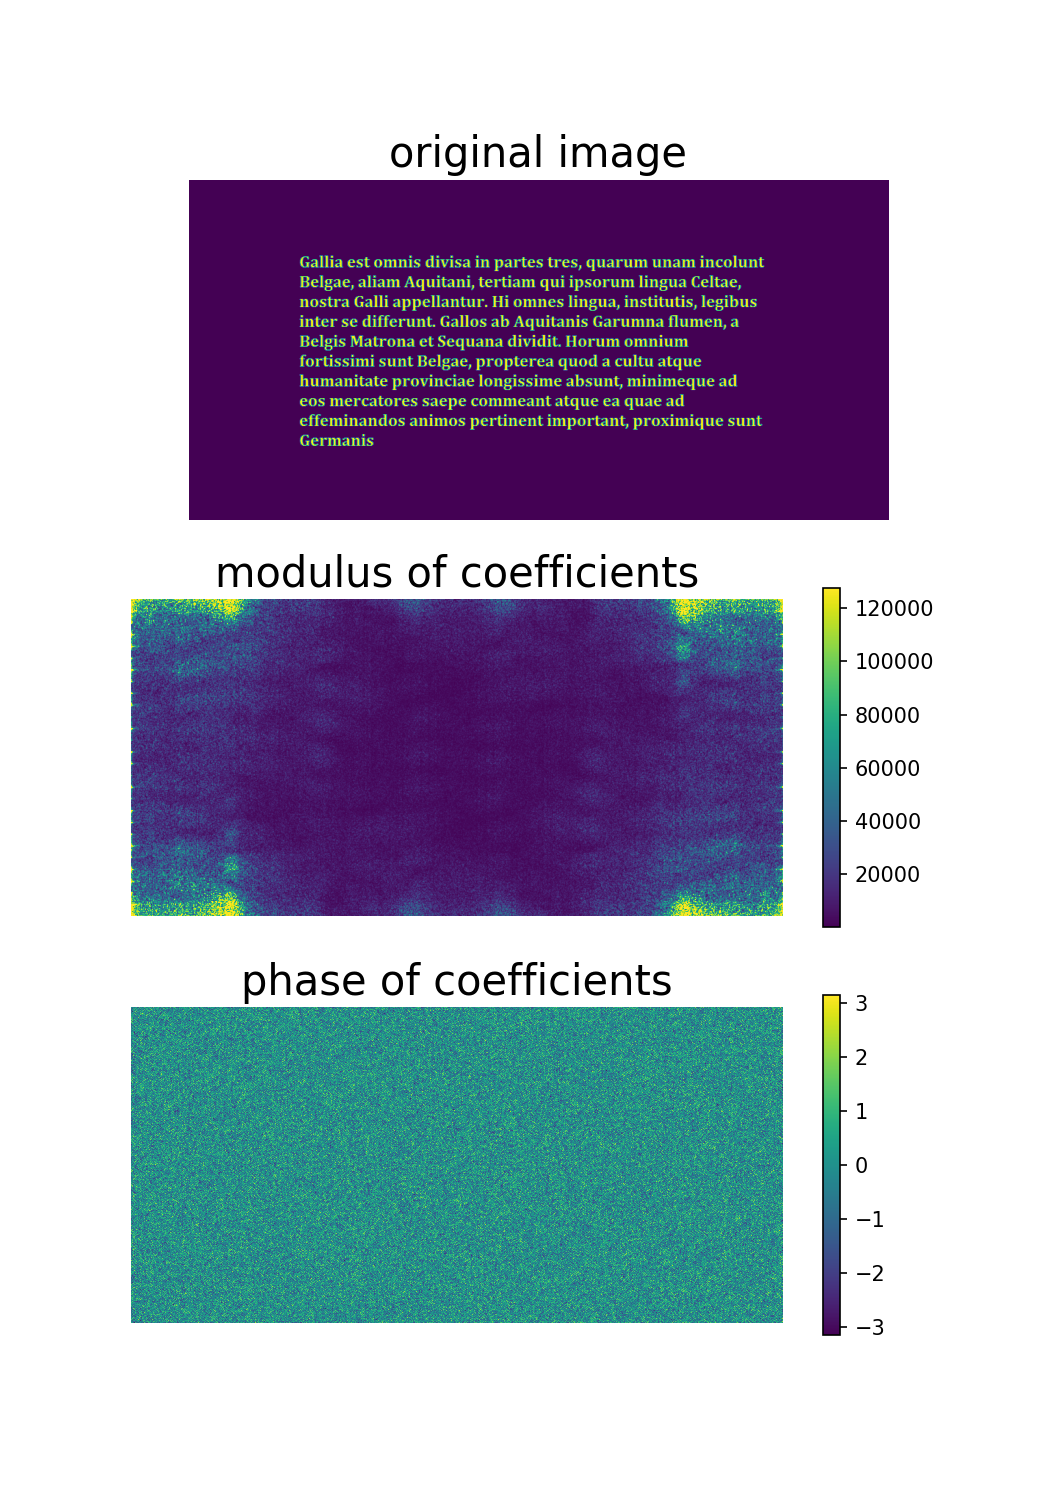

In [4]:
galia = load_text("galia.png").astype(np.float64)
template_e = load_text("galia_e.png").astype(np.float64)
h, w = galia.shape
visualise_dft(galia)

In [5]:
mod, angle = fourier_components(galia)
mod /= np.max(mod)
big_num_idx = mod.flatten().argsort()[int((mod.shape[0]*mod.shape[1])*0.99)]
mod.flatten()[big_num_idx]

0.016869487572068215

## Wizualizacja na sztucznym obrazie

Poniższa wizualizacja także pokazuje wartości modułu i fazy, lecz na prostszym, syntetycznym obrazie. Ma ona na celu zapewnienie prostszego do analizy przykładu pozbawionego szumu.

In [6]:
from matplotlib.widgets import Slider

<IPython.core.display.Javascript object>


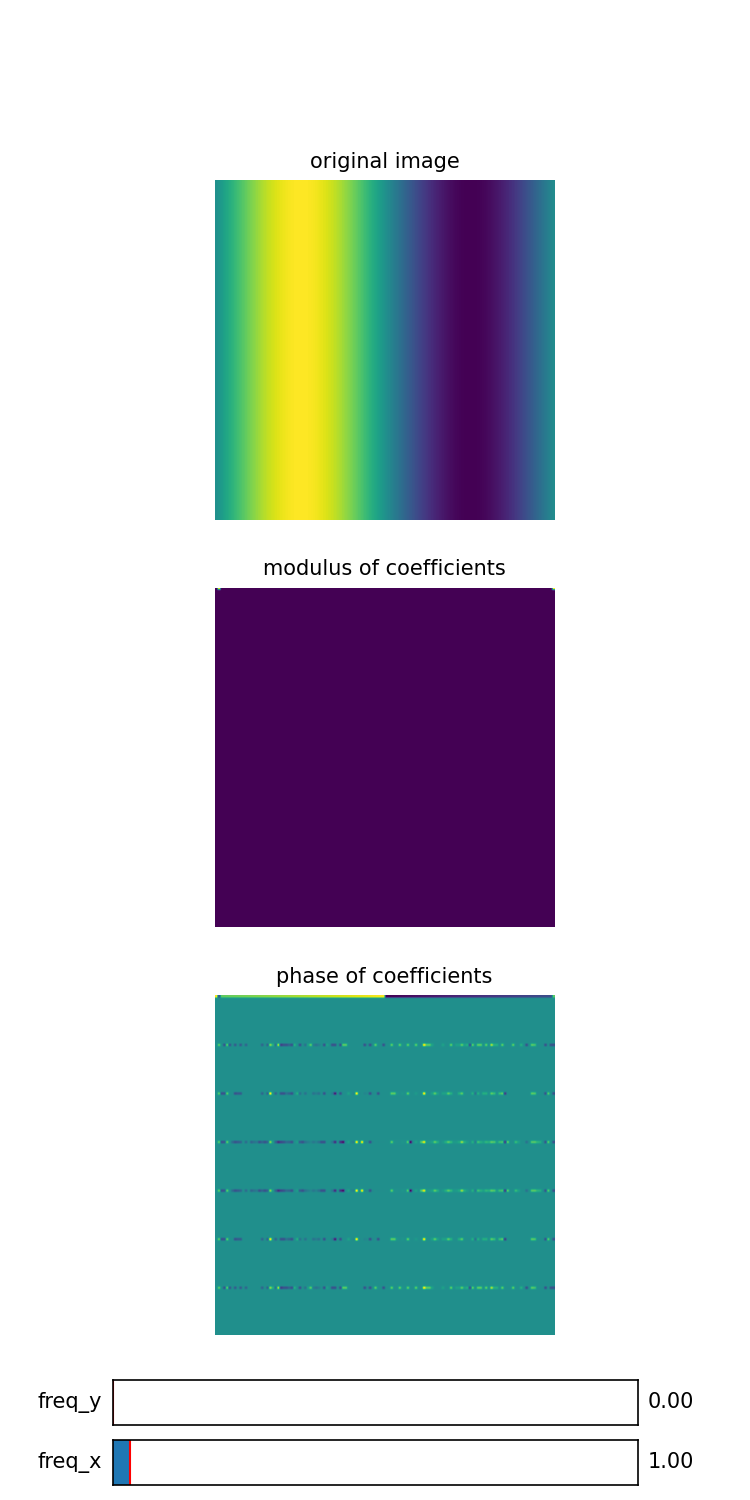

In [7]:
TWOPI = 2*np.pi
font_size = 10
freq_x = 1
freq_y = 0

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,10))
axes[0].set_title("original image", fontdict={"fontsize": font_size})
axes[1].set_title("modulus of coefficients", fontdict={"fontsize": font_size})
axes[2].set_title("phase of coefficients", fontdict={"fontsize": font_size})
for ax in axes: ax.axis('off')
x = np.arange(0.0, TWOPI, 0.05)
y = np.arange(0.0, TWOPI, 0.05)
spacex,spacey = np.meshgrid(x, x)
space = spacex*freq_x+spacey*freq_y

img = np.sin(space)
img_obj = []
img_obj.append(axes[0].imshow(img))
mod, angle = fourier_components(img)
img_obj.append(axes[1].imshow(mod))
img_obj.append(axes[2].imshow(angle))

locx = plt.axes([0.15, 0.01, 0.7, 0.03])
locy = plt.axes([0.15, 0.05, 0.7, 0.03])
x_slider = Slider(locx, 'freq_x', 0, 30, valinit=freq_x)
y_slider = Slider(locy, 'freq_y', 0, 30, valinit=freq_y)

def update_x(val):
    global freq_x
    freq_x = val
    space[:,:] = spacex*freq_x + spacey*freq_y
    img = np.sin(space)
    mod, angle = fourier_components(img)
    img_obj[0].set_data(img)
    img_obj[1].set_data(mod)
    img_obj[2].set_data(angle)
    fig.canvas.draw_idle()
    
    
def update_y(val):
    global freq_y
    freq_y = val
    space = spacex*freq_x + spacey*freq_y
    img = np.sin(space)
    mod, angle = fourier_components(img)
    img_obj[0].set_data(img)
    img_obj[1].set_data(mod)
    img_obj[2].set_data(angle)
    fig.canvas.draw_idle()

x_slider.on_changed(update_x)
y_slider.on_changed(update_y)

plt.show()

## Obliczanie korelacji

Twierdzenie o splocie:  
$x\star y = DFT^{-1}[DFT\{x\}*DFT\{y\}]$ 
Pozwala na szybkie obliczenie splotu przy pomocy dyskretynej transformaty Fouriera. Zakładając obraz i wzorzec o rozmiarach NxN i TxT złożności obliczeniowe wynoszą odpowiednio $O(N^2W^2)$ i $O(N^2)$

In [8]:
def corr(img, template):
    h, w = img.shape
    return (ifft2(fft2(img)*fft2(np.rot90(template,2),[h,w]))).astype(np.float64)

C = corr(galia, template_e)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


Jak widać zastosowanie DTF powoduje znaczne przyspieszenie - na przykładowych danych aż 25-krotne

In [9]:
%%timeit
C = corr(galia, template_e)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


143 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
def slow_corr(img, template):
    C = np.zeros((h,w), dtype=np.float64)
    for i in range(h - 13):
        for j in range(w - 13):
            C[i+12,j+12] = np.sum(img[i:i+13,j:j+13]*template[:,:])
    return C
C_slow = slow_corr(galia, template_e)

In [27]:
%%timeit
slow_corr(galia, template_e)

3.27 s ± 97.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
np.allclose(C, C_slow)

True

In [ ]:
# fig = plt.figure(figsize=(6,6))
# ax = plt.axes(projection='3d')
# X = np.linspace(-10, 10, w)
# Y = np.linspace(-10, 10, h)
# X, Y = np.meshgrid(X, Y)
# #R = 
# # Plot the surface.
# surf = ax.plot_surface(X, Y, C)
# #ax.set_zlim(-1.01, 15.01)
# plt.show()

<IPython.core.display.Javascript object>


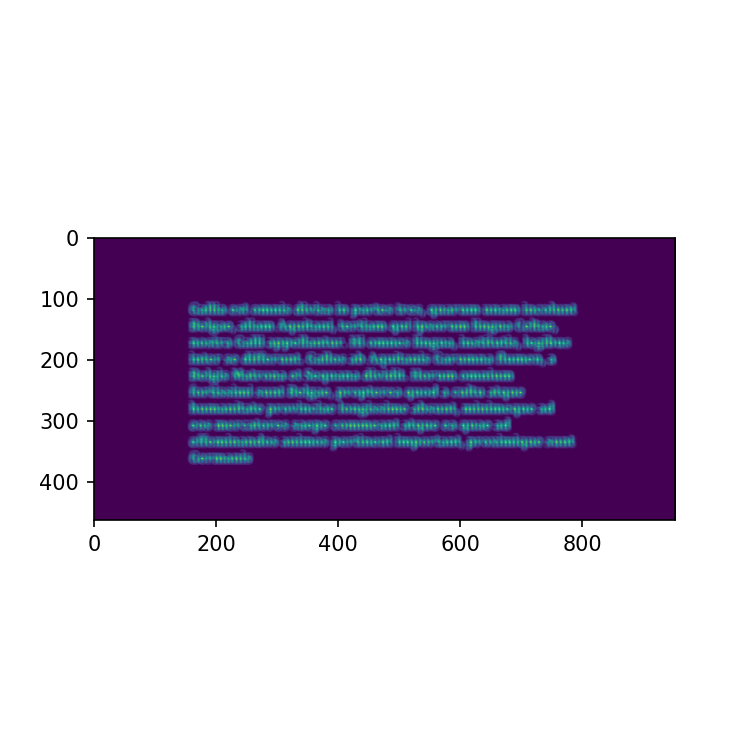

In [28]:
plt.figure(figsize=(5,5))
plt.imshow(C)
plt.show()

Dokonujemy normalizacji korelacji tak, aby jej wartości leżały w przedziale \[0, 1\] celem ułatwienia poszukiwania maximów.

In [29]:
def normalise(x):
    return (x - np.min(x))/np.max(x)

C = normalise(C)

Funkcja `count_max(C, template, threshold)` zlicza i zaznacza wszystkie lokalne maxima w macierzy `C`. Aby maximum zostało zliczone dla i,j jego wartość musi być większa niż `threshold` oraz nie może być w jego otoczeniu (zdefiniowanym przez `template`) wartości większych niż C\[i,j\].

In [31]:
def count_max(C, template=(13,13), threshold=0.9):
    h, w = template
    y, x = h//2, w//2
    count = 0
    maxima = np.zeros(shape=C.shape)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
           # print(i,j)
            if C[i,j] > threshold:
                r = np.sum(C[i-y:i+y+1,j-x:j+x+1]>=C[i,j])
              #  r = np.sum(C[i-h:i+1,j-w:j+1]>=C[i,j])
                if r==1:
                  #  print(C[i-x:i+x,j-y:j+y]>=C[i,j])
                    maxima[i-h:i+1,j-w:j+1] = 255
                    count+=1
    return count, maxima
#c,_ = count_max(maximum_filter(C, size=(13,13)))
#print(c)
c, maxima = count_max(C, threshold=0.9)
print(c)

43


<IPython.core.display.Javascript object>


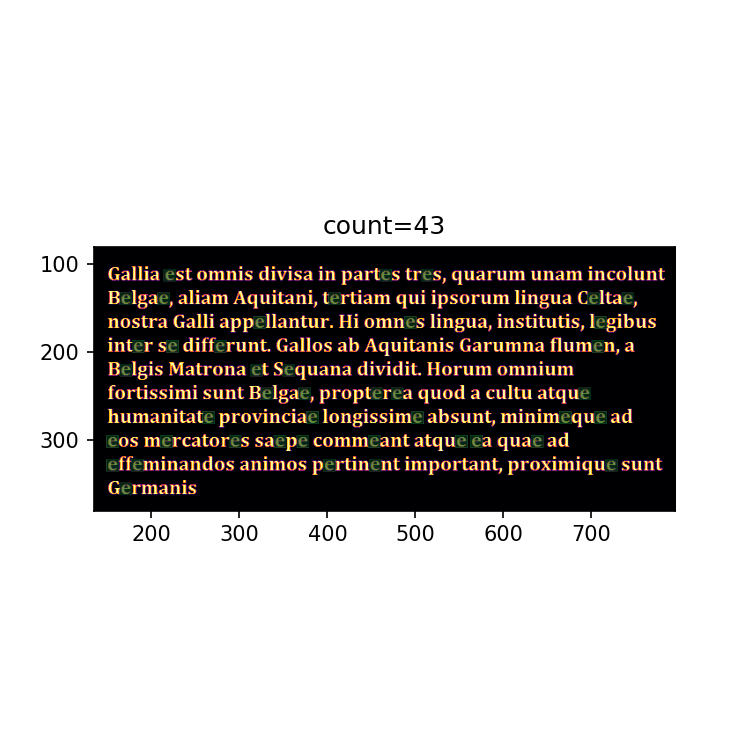

In [33]:
def show_max(background, maxima, alpha=0.6, cmap_back=None, cmap_max=None, title=""):
    plt.figure(figsize=(5,5))
    plt.imshow(background, cmap=cmap_back)
    mask = np.zeros(maxima.shape)
    mask[maxima != 0] = alpha
    plt.imshow(maxima, alpha=mask, cmap=cmap_max)
    plt.title(title)
    plt.show()
    
show_max(galia, maxima, cmap_back='inferno', cmap_max='Greens', title=f"count={c}")

## Ryby

In [34]:
school = np.array(Image.open("school.jpg")).astype(np.float64)
template_fish =  np.array(Image.open("fish1.png")).astype(np.float64)
h, w, _ = school.shape

In [35]:
C = [corr(img, temp).swapaxes(0,1) for img,temp in zip(school.swapaxes(0,2),template_fish.swapaxes(0,2))]
C = np.mean(C, axis=0)
C = normalise(C)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [ ]:
# school = np.array(Image.open("school.jpg").convert("YCbCr")).astype(np.float64)[:,:,0]
# template_fish =  np.array(Image.open("fish1.png").convert("YCbCr")).astype(np.float64)[:,:,0]
# h, w = school.shape
# C = corr(school, template_fish)
# C = normalise(C)

<IPython.core.display.Javascript object>


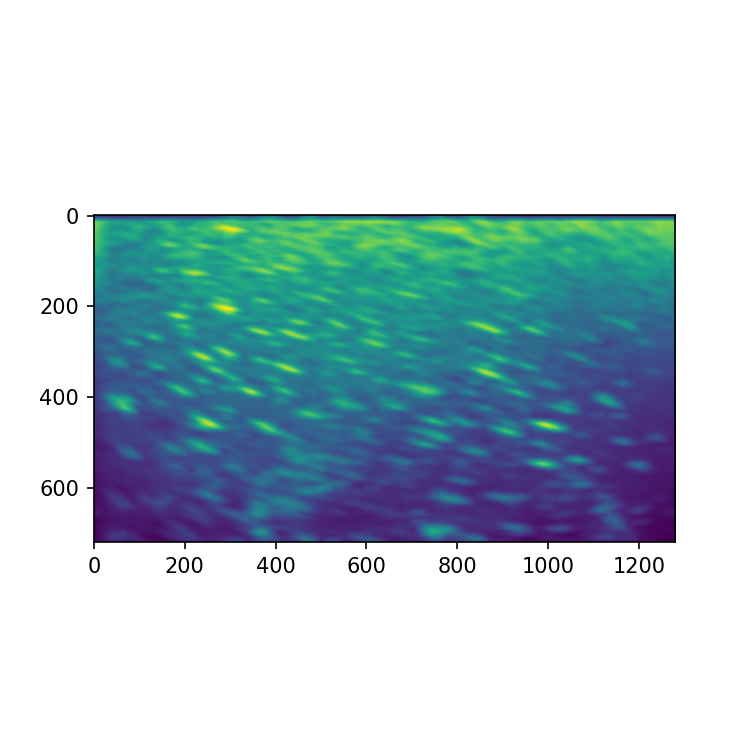

In [36]:
plt.figure(figsize=(5,5))
plt.imshow(C)
plt.show()

<IPython.core.display.Javascript object>


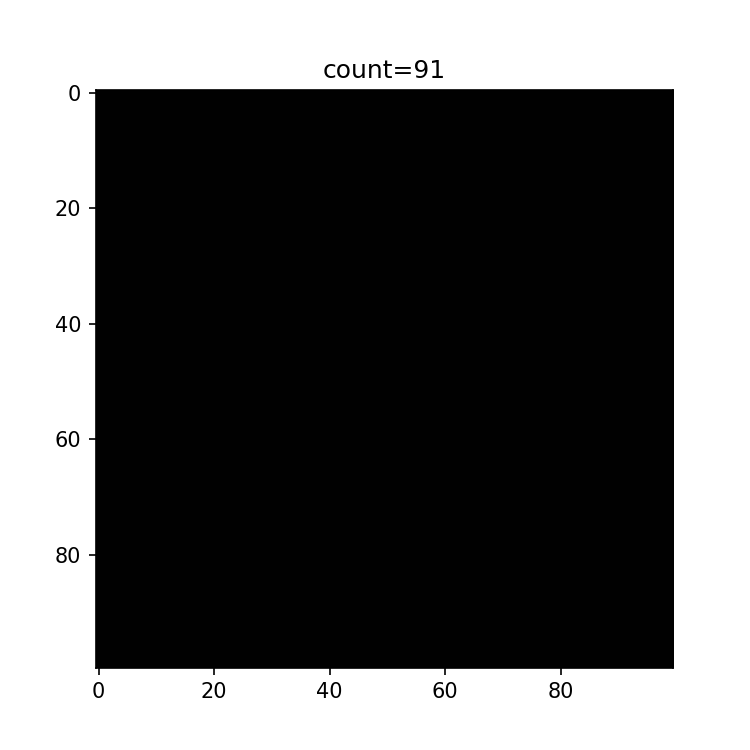

In [44]:
def show_example(C, threshold):
    c, maxima = count_max(C, template=template_fish.shape[:2],threshold=threshold)
    show_max(school.astype(np.uint8), maxima, alpha=0.4, cmap_max="Reds", title=f"count={c}")
    
show_example(C, 0.6)

<IPython.core.display.Javascript object>


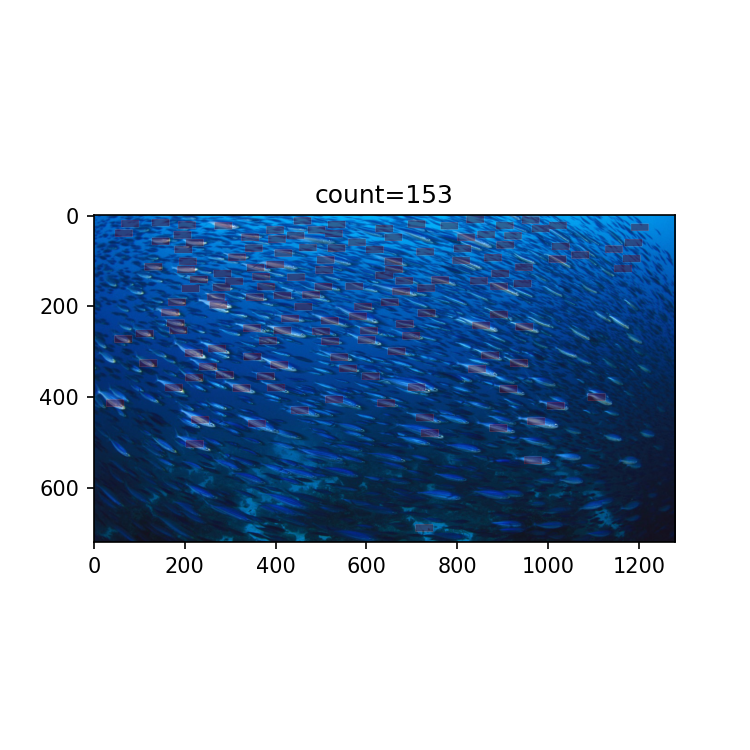

In [38]:
show_example(C, 0.5)

<IPython.core.display.Javascript object>


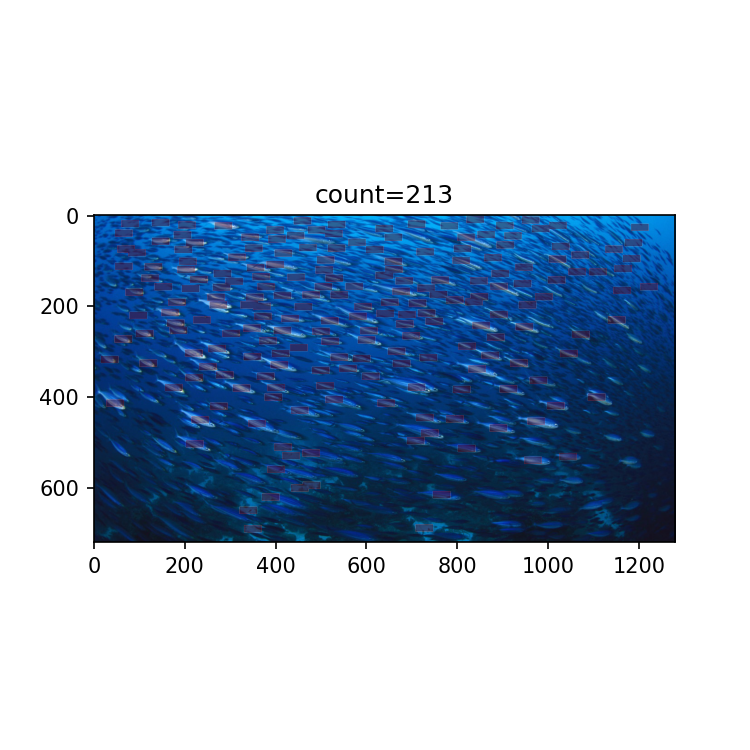

In [39]:
show_example(C, 0.4)

Zliczenie ryb ze zdjęcia przedstawionym sposobem okazuje się zadaniem skrajnie trudnym. Dla dużych wartośći progu sporo ryb zostaje pominiętych, z kolei dla małych zliczone zostają duże ilości niewyraźnych ryb z tła, które nie powinny być wykryte przez wzorzec.  
Problemy:
- różne kąty nachylenia ryb
- zmienne oświetlenie
- zmienna odległość od kamery, a co za tym idzie wielkość na zdjęciu

# OCR

In [56]:
from PIL import ImageFont
from PIL import ImageDraw 

In [76]:
text = """> szerszen wpada do pokoju
> dowiedz sie, ze szerszenie widza w podczerwieni
> przesylacie sobie piosenki"""

<IPython.core.display.Javascript object>


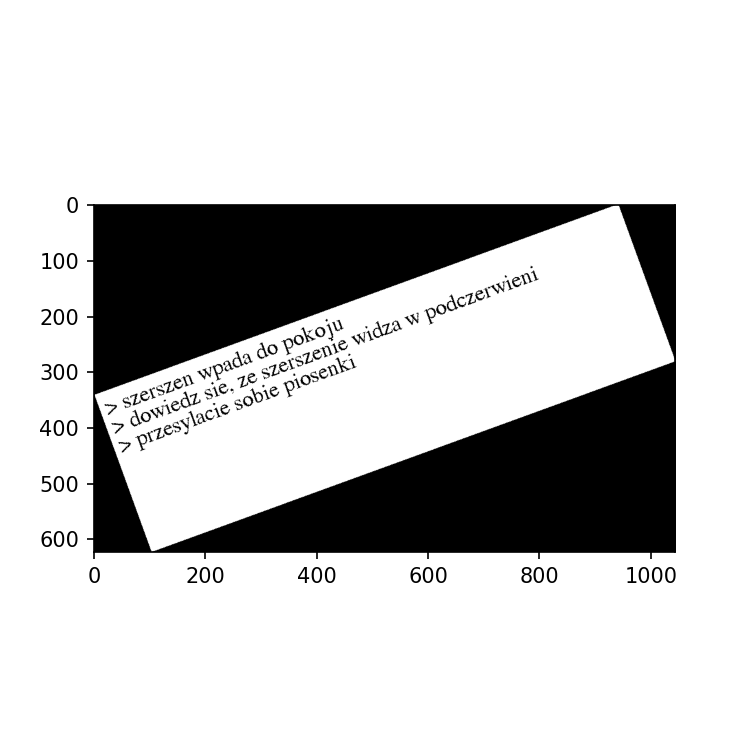

In [103]:
img = Image.fromarray(np.ones((300,1000))*255)
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSerif.ttf", size=40)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((10, 10),text, font=font)
plt.figure(figsize=(5,5))
plt.imshow(img.rotate(20, expand=True))
plt.show()